# Hazard: winter windstorms / extratropical cyclones in Europe
## Or: The StormEurope hazard subclass of CLIMADA

Auth: Jan Hartman  & Thomas Röösli  
Date: 2018-04-26 & 2020-03-03

This notebook will give a quick tour of the capabilities of the StormEurope hazard class. This includes functionalities to apply probabilistic alterations to historical storms.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [15, 10]

## Reading Data

StormEurope was written under the presumption that you'd start out with [WISC](https://wisc.climate.copernicus.eu/wisc/#/help/products#footprint_section) storm footprint data in netCDF format. This notebook works with a demo dataset. If you would like to work with the real data: (1) Please follow the link and download the file C3S_WISC_FOOTPRINT_NETCDF_0100.tgz from the Copernicus Windstorm Information Service, (2) unzip it (3) uncomment the last two lines in the following codeblock and (4) adjust the variable "WISC_files".

We first construct an instance and then point the reader at a directory containing compatible `.nc` files. Since there are other files in there, we must be explicit and use a globbing pattern; supplying incompatible files will make the reader fail.

The reader actually calls `climada.util.files_handler.get_file_names`, so it's also possible to hand it an explicit list of filenames, or a dirname, or even a list of glob patterns or directories. 

In [2]:
from climada.hazard import StormEurope
from climada.util.constants import WS_DEMO_NC

storm_instance = StormEurope.from_footprints(WS_DEMO_NC)

# WISC_files = '/path/to/folder/C3S_WISC_FOOTPRINT_NETCDF_0100/fp_era[!er5]*_0.nc'
# storm_instance = StormEurope.from_footprints(WISC_files)

$CLIMADA_SRC/climada/hazard/centroids/centr.py:822: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  xy_pixels = self.geometry.buffer(res / 2).envelope


## Introspection

Let's quickly see what attributes this class brings with it:

In [3]:
?storm_instance

Type:           StormEurope
String form:    <climada.hazard.storm_europe.StormEurope object at 0x7f2a986b4c70>
File:           ~/code/climada_python/climada/hazard/storm_europe.py
Docstring:     
A hazard set containing european winter storm events. Historic storm
events can be downloaded at http://wisc.climate.copernicus.eu/ and read
with `from_footprints`. Weather forecasts can be automatically downloaded from
https://opendata.dwd.de/ and read with from_icon_grib(). Weather forecast
from the COSMO-Consortium http://www.cosmo-model.org/ can be read with
from_cosmoe_file().

Attributes
----------
ssi_wisc : np.array, float
    Storm Severity Index (SSI) as recorded in
    the footprint files; apparently not reproducible from the footprint
    values only.
ssi : np.array, float
    SSI as set by set_ssi; uses the Dawkins
    definition by default.
Init docstring: Calls the Hazard init dunder. Sets unit to 'm/s'.


You could also try listing all permissible methods with `dir(storm_instance)`, but since that would include the methods from the `Hazard` base class, you wouldn't know what's special. The best way is to read the source: uncomment the following statement to read more.

In [4]:
# StormEurope??

## Into the Storm Severity Index (SSI)

The SSI, according to [Dawkins et al. 2016](https://doi.org/10.5194/nhess-16-1999-2016) or [Lamb and Frydendahl, 1991](https://dx.doi.org/10.2307/215206), can be set using `set_ssi`. For demonstration purposes, I show the default arguments. (Check also the defaults using `storm_instance.calc_ssi?`, the method for which set_ssi is a wrapper.)

We won't be using the `plot_ssi` functionality just yet, because we only have two events; the graph really isn't informative. After this, we'll generate some more storms to make that plot more aesthetically pleasing.

In [5]:
storm_instance.set_ssi(
    method="wind_gust",
    intensity=storm_instance.intensity,
    # the above is just a more explicit way of passing the default
    on_land=True,
    threshold=25,
    sel_cen=None,
    # None is default. sel_cen could be used to subset centroids
)

## Probabilistic Storms

This class allows generating probabilistic storms from historical ones according to a method outlined in [Schwierz et al. 2010](https://doi.org/10.1007/s10584-009-9712-1). This means that per historical event, we generate 29 new ones with altered intensities. Since it's just a bunch of vector operations, this is pretty fast. 

However, we should not return the entire probabilistic dataset in-memory: in trials, this used up 60 GB of RAM, thus requiring a great amount of swap space. Instead, we must select a country by setting the `reg_id` parameter to an ISO_N3 country code used in the [Natural Earth](http://naturalearthdata.com/) dataset. It is also possible to supply a list of ISO codes. If your machine is up for the job of handling the whole dataset, set the `reg_id` parameter to `None`.

Since assigning each centroid a country ID is a rather inefficient affair, you may need to wait a minute or two for the entire WISC dataset to be processed. For the small demo dataset, it runs pretty quickly.

2020-03-05 10:29:31,845 - climada.hazard.centroids.centr - INFO - Setting geometry points.
2020-03-05 10:29:32,248 - climada.hazard.centroids.centr - DEBUG - Setting region_id 9944 points.
2020-03-05 10:29:32,466 - climada.util.coordinates - DEBUG - Setting region_id 9944 points.
2020-03-05 10:29:33,506 - climada.hazard.storm_europe - INFO - Commencing probabilistic calculations
2020-03-05 10:29:33,620 - climada.hazard.storm_europe - INFO - Generating new StormEurope instance
2020-03-05 10:29:33,663 - climada.util.checker - DEBUG - Hazard.ssi not set. 
2020-03-05 10:29:33,664 - climada.util.checker - DEBUG - Hazard.ssi_wisc not set. 
2020-03-05 10:29:33,665 - climada.util.checker - DEBUG - Hazard.event_name not set. Default values set.


C:\shortpaths\GitHub\climada_python\climada\util\plot.py:311: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


Wall time: 2.24 s


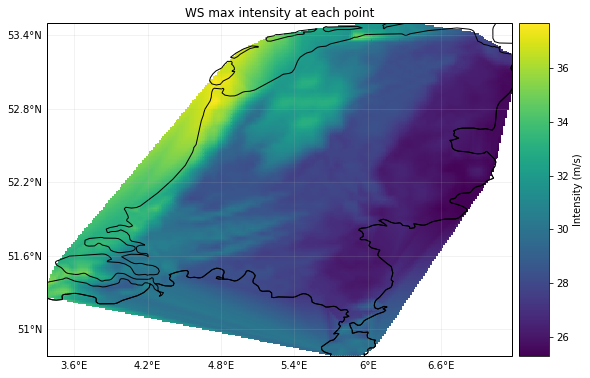

In [7]:
%%time
storm_prob = storm_instance.generate_prob_storms(reg_id=528)
storm_prob.plot_intensity(0);

We can get much more fancy in our calls to `generate_prob_storms`; the keyword arguments after `ssi_args` are passed on to `_hist2prob`, allowing us to tweak the probabilistic permutations.

In [7]:
ssi_args = {
    "on_land": True,
    "threshold": 25,
}

storm_prob_xtreme = storm_instance.generate_prob_storms(
    reg_id=[56, 528],  # BEL and NLD
    spatial_shift=2,
    ssi_args=ssi_args,
    power=1.5,
    scale=0.3,
)

We can now check out the SSI plots of both these calculations. The comparison between the historic and probabilistic ssi values, only makes sense for the full dataset.

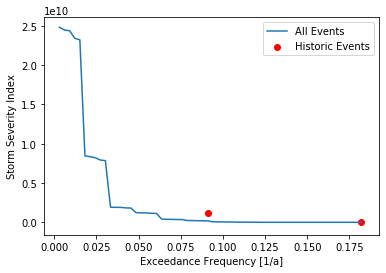

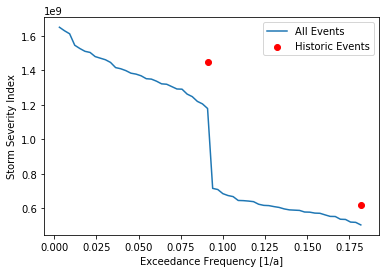

(<Figure size 1080x720 with 1 Axes>,
 <AxesSubplot:xlabel='Exceedance Frequency [1/a]', ylabel='Storm Severity Index'>)

In [10]:
storm_prob_xtreme.plot_ssi(full_area=True)
storm_prob.plot_ssi(full_area=True);